In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import warnings
warnings.filterwarnings('ignore')
plt.style.use('default')
sns.set_palette("husl")

In [2]:
telo_1999 = pd.read_sas('data/TELO_A.xpt')
telo_2001 = pd.read_sas('data/TELO_B.xpt')

demo_1999 = pd.read_sas('data/DEMO.xpt')
demo_2001 = pd.read_sas('data/DEMO_B.xpt')

paq_1999 = pd.read_sas('data/PAQ.xpt')
paq_2001 = pd.read_sas('data/PAQ_B.xpt')

print("Dataset shapes:")
print(f"Telomere 1999-2000: {telo_1999.shape}")
print(f"Telomere 2001-2002: {telo_2001.shape}")
print(f"Demographics 1999-2000: {demo_1999.shape}")
print(f"Demographics 2001-2002: {demo_2001.shape}")
print(f"Physical Activity 1999-2000: {paq_1999.shape}")
print(f"Physical Activity 2001-2002: {paq_2001.shape}")

Dataset shapes:
Telomere 1999-2000: (3570, 3)
Telomere 2001-2002: (4269, 3)
Demographics 1999-2000: (9965, 144)
Demographics 2001-2002: (11039, 37)
Physical Activity 1999-2000: (9188, 21)
Physical Activity 2001-2002: (10094, 21)


In [3]:
telo_vars = ['SEQN', 'TELOMEAN', 'TELOSTD'] # id number, tel length mean and tel length std
telo_1999_clean = telo_1999[telo_vars].copy()
telo_2001_clean = telo_2001[telo_vars].copy()

demo_vars = ['SEQN', 'RIDAGEYR', 'RIAGENDR', 'RIDRETH1', 'RIDEXPRG'] # age, gender, race, pregnancy status
demo_1999_clean = demo_1999[demo_vars].copy()
demo_2001_clean = demo_2001[demo_vars].copy()

paq_vars = ['SEQN', 'PAD020', 'PAQ050Q', 'PAQ050U', 'PAD080',
           'PAD200', 'PAD320', 'PAD440', 'PAD460', 'PAQ180',
           'PAQ500', 'PAQ520', 'PAQ540'] 
# walked or biked in past 30 days, times walked or biked, unit of measurement, how long per day,
# vigorous activity in past 30 days, moderate act in past 30 days, muscle strengthening activities, number of times in the past 30 days, 
# avg level of physical activity each day, activity comparison last mo-last yr, compare activity w/ others same age, compare activity with 10 yrs ago

paq_1999_clean = paq_1999[paq_vars].copy()
paq_2001_clean = paq_2001[paq_vars].copy()

telo_1999_clean['CYCLE'] = '1999-2000'
telo_2001_clean['CYCLE'] = '2001-2002'
demo_1999_clean['CYCLE'] = '1999-2000'
demo_2001_clean['CYCLE'] = '2001-2002'
paq_1999_clean['CYCLE'] = '1999-2000'
paq_2001_clean['CYCLE'] = '2001-2002'

In [4]:
telo_combined = pd.concat([telo_1999_clean, telo_2001_clean], ignore_index=True)
demo_combined = pd.concat([demo_1999_clean, demo_2001_clean], ignore_index=True)
paq_combined = pd.concat([paq_1999_clean, paq_2001_clean], ignore_index=True)

df = telo_combined.merge(demo_combined, on=['SEQN', 'CYCLE'], how='inner')
df = df.merge(paq_combined, on=['SEQN', 'CYCLE'], how='inner')

print(f"Combined dataset shape: {df.shape}")
print(f"Number of participants w/ complete telomere and demographic data: {len(df)}")

Combined dataset shape: (7839, 20)
Number of participants w/ complete telomere and demographic data: 7839


In [5]:
print(f"Initial sample size: {len(df)}")

df_clean = df[df['RIDEXPRG'] != 1].copy()
print(f"After excluding pregnant women: {len(df_clean)}")

df_clean = df_clean.dropna(subset=['TELOMEAN'])
print(f"After excluding missing telomere data: {len(df_clean)}")

df_clean = df_clean[df_clean['RIDAGEYR'] >= 20].copy()
print(f"After excluding participants under 20 years: {len(df_clean)}")

df_clean = df_clean[df_clean['RIDAGEYR'] <= 85].copy()
print(f"Final analytical sample: {len(df_clean)}")

Initial sample size: 7839
After excluding pregnant women: 7392
After excluding missing telomere data: 7380
After excluding participants under 20 years: 7379
Final analytical sample: 7379


In [6]:
df_clean['TeloLength_bp'] = 3274 + 2413 * df_clean['TELOMEAN']

df_clean['AgeGroup'] = pd.cut(df_clean['RIDAGEYR'],
                             bins=[20, 40, 60, 85],
                             labels=['20-39', '40-59', '60+'],
                             include_lowest=True)

df_clean['Gender'] = df_clean['RIAGENDR'].map({1: 'Male', 2: 'Female'})

activity_mapping = {1: 'Sedentary', 2: 'Light Activity', 3: 'Moderate Activity', 4: 'Heavy Activity'}
df_clean['ActivityLevel'] = df_clean['PAQ180'].map(activity_mapping)

In [7]:
race_mapping = {
    1: 'Mexican American',
    2: 'Other Hispanic',
    3: 'Non-Hispanic White',
    4: 'Non-Hispanic Black',
    5: 'Other/Multi-racial'
}

df_clean['Race'] = df_clean['RIDRETH1'].map(race_mapping)


print(df_clean.columns)

Index(['SEQN', 'TELOMEAN', 'TELOSTD', 'CYCLE', 'RIDAGEYR', 'RIAGENDR',
       'RIDRETH1', 'RIDEXPRG', 'PAD020', 'PAQ050Q', 'PAQ050U', 'PAD080',
       'PAD200', 'PAD320', 'PAD440', 'PAD460', 'PAQ180', 'PAQ500', 'PAQ520',
       'PAQ540', 'TeloLength_bp', 'AgeGroup', 'Gender', 'ActivityLevel',
       'Race'],
      dtype='object')


In [8]:
df_clean['TransportActivity'] = df_clean['PAD020'].map({1: 'Yes', 2: 'No', 3: 'Unable'})

def convert_to_weekly_frequency(row):
    if pd.isna(row['PAQ050Q']) or pd.isna(row['PAQ050U']):
        return np.nan

    freq = row['PAQ050Q']
    unit = row['PAQ050U']

    if unit == 1:  # per day
        return freq * 7
    elif unit == 2:  # per week
        return freq
    elif unit == 3:  # per month
        return freq / 4.33  # approximate weeks per month
    else:
        return np.nan

df_clean['TransportFreq_weekly'] = df_clean.apply(convert_to_weekly_frequency, axis=1)

df_clean['VigorousActivity'] = df_clean['PAD200'].map({1: 'Yes', 2: 'No', 3: 'Unable'})
df_clean['ModerateActivity'] = df_clean['PAD320'].map({1: 'Yes', 2: 'No', 3: 'Unable'})
df_clean['StrengthActivity'] = df_clean['PAD440'].map({1: 'Yes', 2: 'No', 3: 'Unable'})

def calculate_activity_score(row):
    score = 0

    if row['TransportActivity'] == 'Yes':
        score += 1

    if row['VigorousActivity'] == 'Yes':
        score += 3

    if row['ModerateActivity'] == 'Yes':
        score += 2

    if row['StrengthActivity'] == 'Yes':
        score += 2

    return score

df_clean['ActivityScore'] = df_clean.apply(calculate_activity_score, axis=1)

df_clean['ActivityCategory'] = pd.cut(df_clean['ActivityScore'],
                                     bins=[-1, 0, 2, 4, 8],
                                     labels=['Inactive', 'Low', 'Moderate', 'High'])

In [9]:
print("CONTINUOUS VARIABLES")
continuous_vars = ['RIDAGEYR', 'TELOMEAN', 'TeloLength_bp', 'ActivityScore']
print(df_clean[continuous_vars].describe())

print("\nMISSING DATA SUMMARy")
missing_summary = df_clean.isnull().sum()
missing_pct = (missing_summary / len(df_clean)) * 100
missing_df = pd.DataFrame({
    'Missing_Count': missing_summary,
    'Missing_Percent': missing_pct
}).round(2)
print(missing_df[missing_df['Missing_Count'] > 0].sort_values('Missing_Percent', ascending=False))

CONTINUOUS VARIABLES
          RIDAGEYR     TELOMEAN  TeloLength_bp  ActivityScore
count  7379.000000  7379.000000    7379.000000    7379.000000
mean     50.744274     1.022144    5740.433946       2.389348
std      18.536588     0.280402     676.609836       2.389731
min      20.000000     0.389337    4213.469043       0.000000
25%      36.000000     0.837309    5294.426226       0.000000
50%      49.000000     0.988184    5658.488294       2.000000
75%      66.000000     1.165221    6085.678259       4.000000
max      85.000000     9.420415   26005.461361       8.000000

MISSING DATA SUMMARy
                      Missing_Count  Missing_Percent
PAD080                         5724            77.57
PAQ050U                        5723            77.56
PAQ050Q                        5723            77.56
TransportFreq_weekly           5723            77.56
PAD460                         5700            77.25
RIDEXPRG                       5082            68.87
PAQ540                      

In [10]:
# Distribution of categorical variables
print("CATEGORICAL VARIABLE DISTRIBUTIONS")

categorical_vars = ['Gender', 'Race', 'AgeGroup', 'ActivityLevel', 'ActivityCategory',
                   'TransportActivity', 'VigorousActivity', 'ModerateActivity', 'StrengthActivity']

for var in categorical_vars:
    if var in df_clean.columns:
        print(f"\n{var}:")
        counts = df_clean[var].value_counts(dropna=False)
        percentages = df_clean[var].value_counts(normalize=True, dropna=False) * 100
        result_df = pd.DataFrame({'Count': counts, 'Percentage': percentages.round(1)})
        print(result_df)

CATEGORICAL VARIABLE DISTRIBUTIONS

Gender:
        Count  Percentage
Gender                   
Male     3770        51.1
Female   3609        48.9

Race:
                    Count  Percentage
Race                                 
Non-Hispanic White   3753        50.9
Mexican American     1753        23.8
Non-Hispanic Black   1281        17.4
Other Hispanic        385         5.2
Other/Multi-racial    207         2.8

AgeGroup:
          Count  Percentage
AgeGroup                   
60+        2521        34.2
20-39      2519        34.1
40-59      2339        31.7

ActivityLevel:
                   Count  Percentage
ActivityLevel                       
Light Activity      3889        52.7
Sedentary           1857        25.2
Moderate Activity   1124        15.2
Heavy Activity       500         6.8
NaN                    9         0.1

ActivityCategory:
                  Count  Percentage
ActivityCategory                   
Inactive           2598        35.2
Low                1824   

In [11]:
print("SAMPLE CHARACTERISTICS BY SURVEY CYCLE")

cycle_comparison = df_clean.groupby('CYCLE').agg({
    'RIDAGEYR': ['count', 'mean', 'std'],
    'TELOMEAN': ['mean', 'std'],
    'TeloLength_bp': ['mean', 'std'],
    'ActivityScore': ['mean', 'std']
}).round(3)

cycle_comparison.columns = ['_'.join(col) for col in cycle_comparison.columns]
print(cycle_comparison)

print("\nGender distribution by cycle:")
gender_cycle = pd.crosstab(df_clean['CYCLE'], df_clean['Gender'], normalize='index') * 100
print(gender_cycle.round(1))

print("\nRace distribution by cycle:")
race_cycle = pd.crosstab(df_clean['CYCLE'], df_clean['Race'], normalize='index') * 100
print(race_cycle.round(1))

SAMPLE CHARACTERISTICS BY SURVEY CYCLE
           RIDAGEYR_count  RIDAGEYR_mean  RIDAGEYR_std  TELOMEAN_mean  \
CYCLE                                                                   
1999-2000            3364         51.201        18.470          0.994   
2001-2002            4015         50.361        18.586          1.046   

           TELOMEAN_std  TeloLength_bp_mean  TeloLength_bp_std  \
CYCLE                                                            
1999-2000         0.299            5672.307            721.282   
2001-2002         0.262            5797.515            631.226   

           ActivityScore_mean  ActivityScore_std  
CYCLE                                             
1999-2000               2.205              2.334  
2001-2002               2.544              2.425  

Gender distribution by cycle:
Gender     Female  Male
CYCLE                  
1999-2000    49.1  50.9
2001-2002    48.8  51.2

Race distribution by cycle:
Race       Mexican American  Non-Hispanic B

In [12]:
print("TELOMERE LENGTH BY DEMOGRAPHIC CHARACTERISTICS")

print("Telomere length by age group:")
age_telo = df_clean.groupby('AgeGroup')['TeloLength_bp'].agg(['count', 'mean', 'std']).round(2)
print(age_telo)

print("\nTelomere length by gender:")
gender_telo = df_clean.groupby('Gender')['TeloLength_bp'].agg(['count', 'mean', 'std']).round(2)
print(gender_telo)

print("\nTelomere length by race:")
race_telo = df_clean.groupby('Race')['TeloLength_bp'].agg(['count', 'mean', 'std']).round(2)
print(race_telo)

TELOMERE LENGTH BY DEMOGRAPHIC CHARACTERISTICS
Telomere length by age group:
          count     mean     std
AgeGroup                        
20-39      2519  6035.06  751.73
40-59      2339  5753.15  586.02
60+        2521  5434.24  525.70

Telomere length by gender:
        count     mean     std
Gender                        
Female   3609  5771.25  635.82
Male     3770  5710.93  712.31

Telomere length by race:
                    count     mean     std
Race                                      
Mexican American     1753  5679.90  736.95
Non-Hispanic Black   1281  5882.29  686.50
Non-Hispanic White   3753  5706.79  640.51
Other Hispanic        385  5844.47  671.07
Other/Multi-racial    207  5791.63  581.08


In [13]:
print("PHYSICAL ACTIVITY PATTERNS")

print("Activity category by age group:")
activity_age = pd.crosstab(df_clean['AgeGroup'], df_clean['ActivityCategory'], normalize='index') * 100
print(activity_age.round(1))

print("\nActivity category by gender:")
activity_gender = pd.crosstab(df_clean['Gender'], df_clean['ActivityCategory'], normalize='index') * 100
print(activity_gender.round(1))

print("\nMean activity score by demographics:")
activity_demo = df_clean.groupby(['Gender', 'AgeGroup'])['ActivityScore'].agg(['count', 'mean', 'std']).round(2)
print(activity_demo)

PHYSICAL ACTIVITY PATTERNS
Activity category by age group:
ActivityCategory  Inactive   Low  Moderate  High
AgeGroup                                        
20-39                 26.4  20.4      19.7  33.5
40-59                 35.1  24.2      17.1  23.7
60+                   44.1  29.5      15.0  11.4

Activity category by gender:
ActivityCategory  Inactive   Low  Moderate  High
Gender                                          
Female                38.3  26.0      16.7  19.0
Male                  32.3  23.5      17.7  26.5

Mean activity score by demographics:
                 count  mean   std
Gender AgeGroup                   
Female 20-39      1241  2.83  2.52
       40-59      1121  2.23  2.33
       60+        1247  1.45  1.82
Male   20-39      1278  3.31  2.61
       40-59      1218  2.62  2.47
       60+        1274  1.88  2.00


In [14]:
print(f"Total participants in analytical dataset: {len(df_clean)}")
print(f"Participants from 1999-2000 cycle: {len(df_clean[df_clean['CYCLE'] == '1999-2000'])}")
print(f"Participants from 2001-2002 cycle: {len(df_clean[df_clean['CYCLE'] == '2001-2002'])}")

print(f"\nAge range: {df_clean['RIDAGEYR'].min()} - {df_clean['RIDAGEYR'].max()} years")
print(f"Mean age: {df_clean['RIDAGEYR'].mean():.1f} ± {df_clean['RIDAGEYR'].std():.1f} years")

print(f"\nTelomere length range: {df_clean['TeloLength_bp'].min():.0f} - {df_clean['TeloLength_bp'].max():.0f} bp")
print(f"Mean telomere length: {df_clean['TeloLength_bp'].mean():.0f} ± {df_clean['TeloLength_bp'].std():.0f} bp")

print(f"\nActivity score range: {df_clean['ActivityScore'].min()} - {df_clean['ActivityScore'].max()}")
print(f"Mean activity score: {df_clean['ActivityScore'].mean():.2f} ± {df_clean['ActivityScore'].std():.2f}")

print(f"Participants with complete telomere data: {df_clean['TELOMEAN'].notna().sum()}")
print(f"Participants with complete age data: {df_clean['RIDAGEYR'].notna().sum()}")
print(f"Participants with complete gender data: {df_clean['Gender'].notna().sum()}")
print(f"Participants with complete race data: {df_clean['Race'].notna().sum()}")

print(f"\nFinal analytical dataset ready with {len(df_clean)} participants")

Total participants in analytical dataset: 7379
Participants from 1999-2000 cycle: 3364
Participants from 2001-2002 cycle: 4015

Age range: 20.0 - 85.0 years
Mean age: 50.7 ± 18.5 years

Telomere length range: 4213 - 26005 bp
Mean telomere length: 5740 ± 677 bp

Activity score range: 0 - 8
Mean activity score: 2.39 ± 2.39
Participants with complete telomere data: 7379
Participants with complete age data: 7379
Participants with complete gender data: 7379
Participants with complete race data: 7379

Final analytical dataset ready with 7379 participants


## Regression
#### We're trying to predict age using the following variables 

In [80]:
y = df_clean['RIDAGEYR']

features_reg = ['TELOMEAN', 'Gender', 'Race', 'ActivityLevel', 'ActivityCategory']

In [81]:
#df_clean['ActivityLevel'].fillna(df_clean['ActivityLevel'].mode()[0], inplace=True)
#df_clean['TransportActivity'].fillna(df_clean['TransportActivity'].mode()[0], inplace=True)
X = df_clean[features_reg]

#### Using one-hot encoding for categorical variables

In [82]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer

categorical_cols = ['Gender', 'Race', 'ActivityLevel', 'ActivityCategory']
numerical_cols = [col for col in features_reg if col not in categorical_cols]

X_cat = df_clean[categorical_cols]
X_num = df_clean[numerical_cols]
X_cat = X_cat.astype(str)
imputer = SimpleImputer(strategy='most_frequent')
X_cat_imputed = pd.DataFrame(imputer.fit_transform(X_cat), columns=categorical_cols)

encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
X_cat_encoded_array = encoder.fit_transform(X_cat_imputed)

encoded_feature_names = encoder.get_feature_names_out(categorical_cols)

X_cat_encoded = pd.DataFrame(X_cat_encoded_array, columns=encoded_feature_names, index=df_clean.index)

X_combined = pd.concat([X_num, X_cat_encoded], axis=1)

print("Processed feature matrix shape:", X_combined.shape)
print("Example columns:\n", X_combined.columns[:10])

Processed feature matrix shape: (7379, 16)
Example columns:
 Index(['TELOMEAN', 'Gender_Female', 'Gender_Male', 'Race_Mexican American',
       'Race_Non-Hispanic Black', 'Race_Non-Hispanic White',
       'Race_Other Hispanic', 'Race_Other/Multi-racial',
       'ActivityLevel_Heavy Activity', 'ActivityLevel_Light Activity'],
      dtype='object')


In [83]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

y = df_clean['RIDAGEYR']
X_train, X_test, y_train, y_test = train_test_split(X_combined, y, test_size=0.2, random_state=42)

model = LinearRegression()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error: {mse:.2f}")
print(f"R-squared: {r2:.4f}")

print("\nCoefficients:")
for feature, coef in zip(X_combined.columns, model.coef_):
    print(f"{feature}: {coef:.4f}")

print(f"Intercept: {model.intercept_:.4f}")

Mean Squared Error: 251.48
R-squared: 0.2548

Coefficients:
TELOMEAN: -22.2037
Gender_Female: -0.5825
Gender_Male: 0.5825
Race_Mexican American: -2.5511
Race_Non-Hispanic Black: 0.2869
Race_Non-Hispanic White: 5.4388
Race_Other Hispanic: -1.0788
Race_Other/Multi-racial: -2.0959
ActivityLevel_Heavy Activity: -6.4209
ActivityLevel_Light Activity: 3.4322
ActivityLevel_Moderate Activity: -0.4908
ActivityLevel_Sedentary: 3.4795
ActivityCategory_High: -6.1615
ActivityCategory_Inactive: 4.6324
ActivityCategory_Low: 2.5409
ActivityCategory_Moderate: -1.0118
Intercept: 68.4889


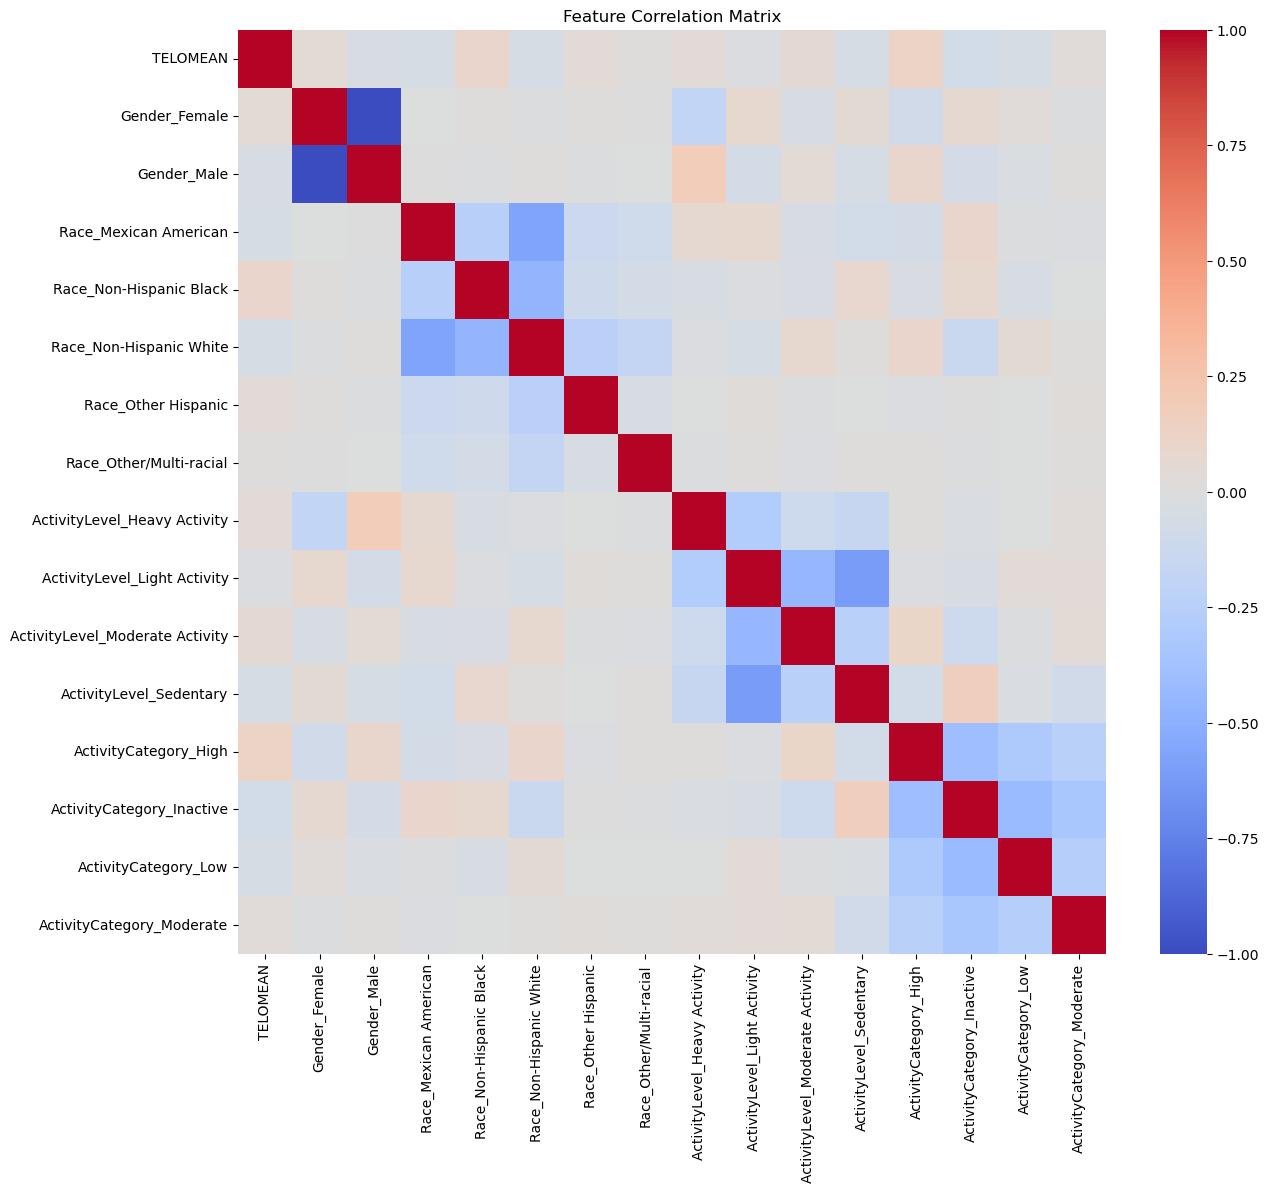

In [84]:
import seaborn as sns
import matplotlib.pyplot as plt

corr_matrix = X_combined.corr()

plt.figure(figsize=(14, 12))
sns.heatmap(corr_matrix, cmap='coolwarm', annot=False, fmt=".2f", center=0)
plt.title("Feature Correlation Matrix")
plt.show()

The variables we used are uncorrelated, we tried to reduce the redundancy but the R^2 of the model won't get higher.

# LogReg

In [53]:
df_results = pd.DataFrame({
    'ActualAge': y_test,
    'PredictedAge': y_pred
})
df_results['AgeGap'] = df_results['PredictedAge'] - df_results['ActualAge']

# Aging faster = 1, Aging slower or same = 0
df_results['FasterAging'] = (df_results['AgeGap'] > 0).astype(int)

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

# Align features
X_gap = X_test.loc[df_results.index]
y_gap = df_results['FasterAging']

X_train_gap, X_test_gap, y_train_gap, y_test_gap = train_test_split(X_gap, y_gap, test_size=0.2, random_state=42)

clf = LogisticRegression()
clf.fit(X_train_gap, y_train_gap)
y_pred_gap = clf.predict(X_test_gap)

from sklearn.metrics import classification_report

print(classification_report(y_test_gap, y_pred_gap))


              precision    recall  f1-score   support

           0       0.64      0.54      0.59       148
           1       0.60      0.70      0.65       148

    accuracy                           0.62       296
   macro avg       0.62      0.62      0.62       296
weighted avg       0.62      0.62      0.62       296



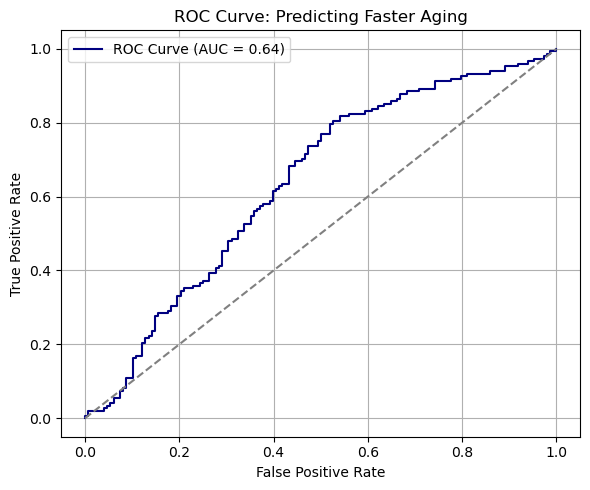

In [54]:
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt

y_prob = clf.predict_proba(X_test_gap)[:, 1]  # probability of class 1 (Faster Aging)

fpr, tpr, thresholds = roc_curve(y_test_gap, y_prob)
auc = roc_auc_score(y_test_gap, y_prob)

plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {auc:.2f})", color="navy")
plt.plot([0, 1], [0, 1], linestyle='--', color="gray")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve: Predicting Faster Aging")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

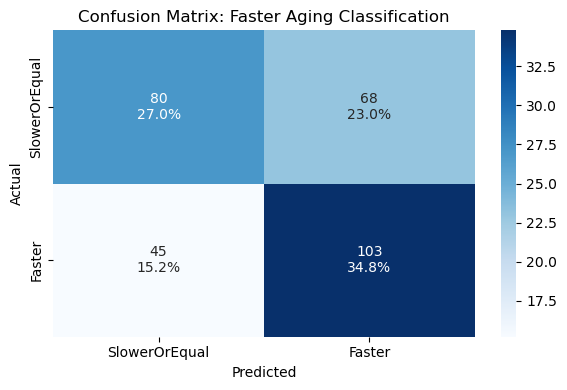

In [56]:
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

def info_cm(y_true, y_pred, class_names=['SlowerOrEqual', 'Faster']):
    cm = confusion_matrix(y_true, y_pred)
    cm_sum = cm.sum()
    cm_pct = cm / cm_sum * 100

    labels = np.array([[f"{val}\n{pct:.1f}%" for val, pct in zip(row_vals, row_pcts)]
                       for row_vals, row_pcts in zip(cm, cm_pct)])

    plt.figure(figsize=(6, 4))
    sns.heatmap(cm_pct, annot=labels, fmt='', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix: Faster Aging Classification')
    plt.tight_layout()
    plt.show()
info_cm(y_test_gap, y_pred_gap)


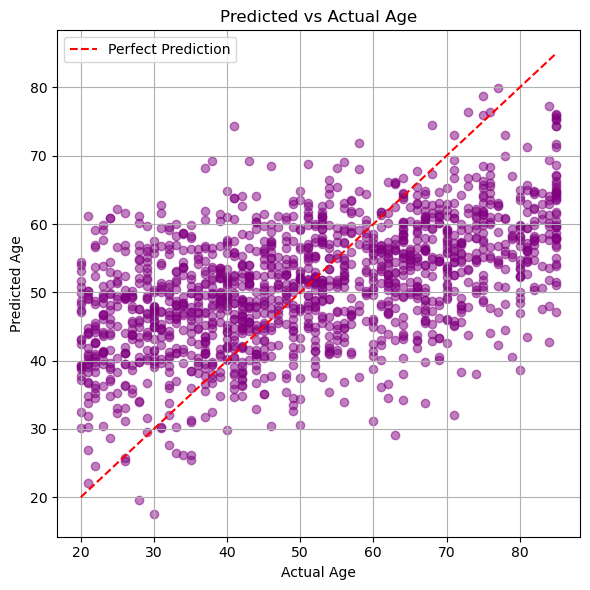

In [58]:
plt.figure(figsize=(6, 6))
plt.scatter(df_results['ActualAge'], df_results['PredictedAge'], alpha=0.5, color='purple')
plt.plot([df_results['ActualAge'].min(), df_results['ActualAge'].max()],
         [df_results['ActualAge'].min(), df_results['ActualAge'].max()],
         'r--', label='Perfect Prediction')
plt.xlabel("Actual Age")
plt.ylabel("Predicted Age")
plt.title("Predicted vs Actual Age")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Lin Reg with only telomere length as main predictor

In [59]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_squared_error, r2_score

y = df_clean['RIDAGEYR']

features = ['TELOMEAN', 'Gender', 'Race']
X = df_clean[features]

numerical_cols = ['TELOMEAN']
categorical_cols = ['Gender', 'Race']

X_num = X[numerical_cols]
X_cat = X[categorical_cols].astype(str)

imputer = SimpleImputer(strategy='most_frequent')
X_cat_imputed = pd.DataFrame(imputer.fit_transform(X_cat), columns=categorical_cols)

encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
X_cat_encoded_array = encoder.fit_transform(X_cat_imputed)
encoded_feature_names = encoder.get_feature_names_out(categorical_cols)
X_cat_encoded = pd.DataFrame(X_cat_encoded_array, columns=encoded_feature_names, index=X.index)

X_combined = pd.concat([X_num, X_cat_encoded], axis=1)

print("Processed feature matrix shape:", X_combined.shape)
print("Example columns:\n", X_combined.columns[:10])

X_train, X_test, y_train, y_test = train_test_split(X_combined, y, test_size=0.2, random_state=42)

model = LinearRegression()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error: {mse:.2f}")
print(f"R-squared: {r2:.4f}\n")

print("Coefficients:")
for feature, coef in zip(X_combined.columns, model.coef_):
    print(f"{feature}: {coef:.4f}")

print(f"\nIntercept: {model.intercept_:.4f}")


Processed feature matrix shape: (7379, 8)
Example columns:
 Index(['TELOMEAN', 'Gender_Female', 'Gender_Male', 'Race_Mexican American',
       'Race_Non-Hispanic Black', 'Race_Non-Hispanic White',
       'Race_Other Hispanic', 'Race_Other/Multi-racial'],
      dtype='object')
Mean Squared Error: 270.90
R-squared: 0.1972

Coefficients:
TELOMEAN: -25.2265
Gender_Female: 0.3643
Gender_Male: -0.3643
Race_Mexican American: -2.4062
Race_Non-Hispanic Black: 0.8726
Race_Non-Hispanic White: 4.5286
Race_Other Hispanic: -0.7854
Race_Other/Multi-racial: -2.2096

Intercept: 74.7767


Classification Report:

              precision    recall  f1-score   support

           0       0.57      0.48      0.52       707
           1       0.58      0.67      0.63       769

    accuracy                           0.58      1476
   macro avg       0.58      0.58      0.57      1476
weighted avg       0.58      0.58      0.58      1476



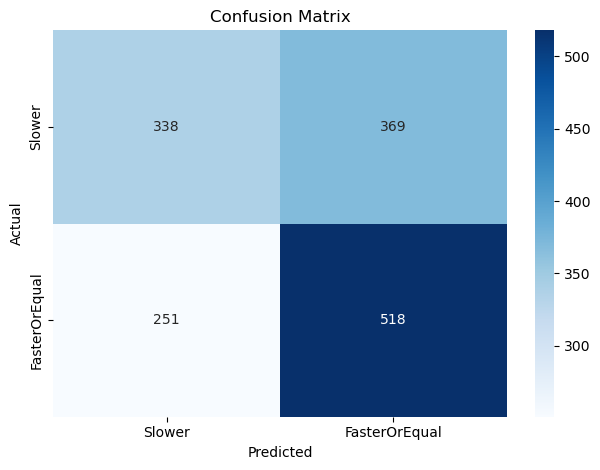

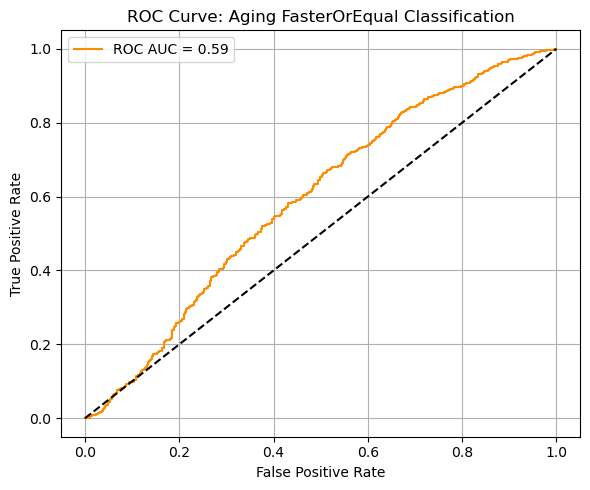

In [60]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
import matplotlib.pyplot as plt
import seaborn as sns

df_results = pd.DataFrame({
    'ActualAge': y_test,
    'PredictedAge': y_pred
})
df_results['AgingFasterOrEqual'] = (df_results['PredictedAge'] >= df_results['ActualAge']).astype(int)

X_test_log = X_test.loc[df_results.index]  # same index

clf = LogisticRegression()
clf.fit(X_test_log, df_results['AgingFasterOrEqual'])

y_prob = clf.predict_proba(X_test_log)[:, 1]
y_pred_class = clf.predict(X_test_log)

print("Classification Report:\n")
print(classification_report(df_results['AgingFasterOrEqual'], y_pred_class))

# Confusion Matrix
cm = confusion_matrix(df_results['AgingFasterOrEqual'], y_pred_class)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Slower', 'FasterOrEqual'],
            yticklabels=['Slower', 'FasterOrEqual'])
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.show()

fpr, tpr, thresholds = roc_curve(df_results['AgingFasterOrEqual'], y_prob)
auc = roc_auc_score(df_results['AgingFasterOrEqual'], y_prob)

plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, label=f"ROC AUC = {auc:.2f}", color='darkorange')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve: Aging FasterOrEqual Classification")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
